In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install mmh3
%pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 836.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.5 MB/s eta 0:00:00


In [22]:
import os, time, hashlib
import mmh3
import numpy as np
import operator
from typing import List
import networkx as nx
from Bio import SeqIO
import matplotlib.pyplot as plt

In [4]:
os.chdir('/content/drive/MyDrive/2024-Spring/02604-bioinformatics/02-604 Bioinformatics Project/code/overlap-MHAP')
print(os.getcwd())
print(os.listdir())

/content/drive/.shortcut-targets-by-id/1rnhxecx1hYdQggbsTQ_Yxcg1AERsOUGq/02-604 Bioinformatics Project/code/overlap-MHAP
['Copy of mhap-funcs-1thru4.ipynb', 'mhap-funcs-1thru5.ipynb', 'filtered_reads.fastq', 'all_sketches_dummy.npy', 'j_mtx_dummy.npy', 'mhap-funcs-April10-testcode.ipynb']


# hyperparameters (GLOBAL): Fig 2 of MHAP paper

In [7]:
CONSTANT_k = 16 # MHAP paper, this is k1 from the paper
CONSTANT_H = 1000  #
seed = 42

# functions

In [8]:
def create_kmers(read: str, k: int)->List[str]:
  # this is number of kmers, and also last idx in the string
  last_kmer_idx = len(read) - k + 1
  all_kmers = ['']*last_kmer_idx
  for i in range(0,last_kmer_idx):
    all_kmers[i] = read[i:i+k]

  return all_kmers

In [9]:
testread_1 = '0123456789'*3
print(f"testread={testread_1}")
test_kmers_1 = create_kmers(testread_1,k=CONSTANT_k)
test_kmers_1

testread=012345678901234567890123456789


['0123456789012345',
 '1234567890123456',
 '2345678901234567',
 '3456789012345678',
 '4567890123456789',
 '5678901234567890',
 '6789012345678901',
 '7890123456789012',
 '8901234567890123',
 '9012345678901234',
 '0123456789012345',
 '1234567890123456',
 '2345678901234567',
 '3456789012345678',
 '4567890123456789']

In [10]:
testread_2 = '0123456789'*3
testread_2 = testread_2[::-1]
print(f"testread={testread_2}")
test_kmers_2 = create_kmers(testread_2,k=CONSTANT_k)
test_kmers_2

testread=987654321098765432109876543210


['9876543210987654',
 '8765432109876543',
 '7654321098765432',
 '6543210987654321',
 '5432109876543210',
 '4321098765432109',
 '3210987654321098',
 '2109876543210987',
 '1098765432109876',
 '0987654321098765',
 '9876543210987654',
 '8765432109876543',
 '7654321098765432',
 '6543210987654321',
 '5432109876543210']

In [11]:
for idx, _ in enumerate(test_kmers_2):
  if idx == 0 or idx == 5 or idx == 7:
    test_kmers_2[idx] = test_kmers_1[idx]

In [12]:
def create_sketch(kmers_read_i: List[str],
                       seed: int)->np.ndarray:
  """
  - kmers_read_i: all kmers for read i
  - seeds: int32 (otherwise, unpredictable), all seeds to be used to create independent hash functions and length needs to be equal to CONSTANT_H
  """
  # sketch_one = np.array([0]*CONSTANT_H)

  # fingerprint_1 = [mmh3.hash64(key=kmer,seed=seed,signed=False) for kmer in kmers_read_i]
  # fingerprint_1 = [mmh3.hash(key=kmer,seed=seed,signed=False) for kmer in kmers_read_i]
  fingerprint_1 = [python_hash32(kmer) for kmer in kmers_read_i]

  # print(fingerprint_1)
  xor_shifts = [xorshift(x) for x in fingerprint_1]
  # sketch[0] = np.min(fingerprint_1)
  sketch_one = np.min(fingerprint_1)
#   print(f"XOR-PRNG Hash Function {0}")
#   print(fingerprint_1)

  the_rest_of_sketch = [np.min([next(next_rng) for next_rng in xor_shifts]) for _ in range(1,CONSTANT_H)]
  # for sketch_idx in range(1,CONSTANT_H):
  #   next_fingerprint = [0]*len(fingerprint_1)
  #   # for idx, next_rng in enumerate(xor_shifts):
  #   #     next_fingerprint[idx] = next(next_rng)

  #   next_fingerprint = [next(next_rng) for next_rng in xor_shifts]
  #   # print(f"XOR-PRNG Hash Function {sketch_idx}")
  #   # print(next_fingerprint)
  #   minmer = np.min(next_fingerprint)
  #   sketch[sketch_idx] = minmer

  return np.array([sketch_one] + the_rest_of_sketch, dtype=np.int32)

def python_hash32(input_string:str):
  # Get the BLAKE2b hash digest as bytes
  hash_digest = hashlib.blake2b(input_string.encode()).digest()
  return int.from_bytes(hash_digest[:4], byteorder='big')

def xorshift(seed):
    """XORShift random number generator"""
    state = seed
    while True:
        state ^= state << 13
        state ^= state >> 17
        state ^= state << 5
        yield state & 0xFFFFFFFF  # Ensure 32-bit output

def jaccard_index(sketch_1, sketch_2):
    diff = list(map(operator.sub, sketch_1, sketch_2))
    return diff.count(0)/len(sketch_1)

In [13]:
test_sketch_1 = create_sketch(test_kmers_1,seed)
test_sketch_1

array([ 136452684,  920535257,   31950462,  120964122,  358575783,
        281741013,  208559121,   59892487,  137454432,   94352504,
        210244909,   18065063,  241138530,  183145643,  118970806,
        189365326,  384229173,  347713301,   57605319,  421679059,
        116287565,   76314421,   22405419, 1015854318,  118475718,
        203305698,  443326977,  348222481,  272446911, 1340420006,
        280426623,  465760996,   20413837,  341676414,  181851557,
       1022930708,  388455791,  756688490,  112963836,    6987118,
          5066264,  552599280,  569486053,  782472856,    2074365,
        142470973,  797299158,    5400359,  577169245,  629279400,
         39056887,  433708350,  130641787,   73477232,  127868615,
        524616502, 1214384199,  630520546,  162867185,  454369342,
         39897431, 1786708938,   62743260,   14930869,  146587631,
        121661710,  148218515,  820366237,  488586470,  296203591,
        187728381,  517921754,  230933882,   15902208,   37133

In [15]:
test_sketch_2 = create_sketch(test_kmers_2,seed)
test_sketch_2

array([ 464462677,  784204124,   31950462,  522516837,  528689036,
        126727919,  161858912,   59892487,  137454432,    8142933,
        775888215,   18065063,  513993643,  139160723,  118970806,
         85895253,   89901332,  254189261,   63580615,  301603854,
        116287565,  427027147,  263961450,  578201377,  118475718,
        328497850,  443326977,   80730426,  156421980,  416340769,
        163651006,  107381793,  161963600,   40840447,   30419094,
         98793107,  258992342,   26015563,  112963836,    6987118,
        389211437,  270217266,   18474348,  604309757,  490176460,
        309237654,  586238072,   26640929,   68688795,  143232808,
        694876994,  225855673,  183603793,   73477232,    8660217,
        104785068,  414403697,  803894512,  221991453,  366855736,
        744178805,  624461261,  484905697, 1348134814, 1241557758,
        121661710,   79309059,  129162055,  224609464,  190987778,
        524363339,   26164153,  760785798,   15902208,   27794

In [ ]:
# def jaccard_index(sketch_1, sketch_2):
#     diff = list(map(operator.sub, sketch_1, sketch_2))
#     return diff.count(0)/len(sketch_1)

In [ ]:
jaccard_index([ 112394020,  207397164, 1176534235,  181114185], [ 112394020,  4, 1176534235,  181114185])

In [ ]:
# NOTE TO SELF: DO EXAMPLE IN FIGURE 1 OF PAPER (and/or from book)
replicates = 2000
testread_1 = "CATGGACCGACCAG" # + "AAA"*replicates
testread_2 = "GCAGTACCGATCGT" # + "AAA"*replicates

seeds = []
for i in range(0,CONSTANT_H):
  seeds.append((i+1)**2)
test_kmers_1 = create_kmers(testread_1,k=CONSTANT_k)
test_kmers_2 = create_kmers(testread_2,k=CONSTANT_k)

test_sketch_1 = create_sketch(test_kmers_1,seeds)
test_sketch_2 = create_sketch(test_kmers_2,seeds)

print(jaccard_index(test_sketch_1, test_sketch_2))
print("===== kmers ======")
print(test_kmers_1)
print(test_kmers_2)
print("===== sketches ======")
print(test_sketch_1)
print(test_sketch_2)

In [ ]:
# def xorshift(seed):
#     """XORShift random number generator"""
#     state = seed
#     while True:
#         state ^= state << 13
#         state ^= state >> 17
#         state ^= state << 5
#         yield state & 0xFFFFFFFF  # Ensure 32-bit output

rng = xorshift(5428513)
random_fingerprints = [next(rng) for _ in range(CONSTANT_H)]
random_fingerprints

# Functions 5-6

In [16]:
def get_all_sketches(reads: List[str], seed:int)->List[np.ndarray]:
  all_sketches: List[np.ndarray] = [None]*len(reads) # type: ignore
  prev_percent = None
  for idx in range(0,len(reads)):
    cur_percent = int((idx+1)/len(reads)*100)
    print(idx,cur_percent)
    if cur_percent % 5 == 0 and cur_percent != prev_percent:
      print(f"cur_percent={cur_percent}")
      prev_percent = cur_percent
    all_kmers_i = create_kmers(reads[idx],k=CONSTANT_k)
    all_sketches[idx] = create_sketch(all_kmers_i,seed)

  return all_sketches

def get_jaccard_matrix(all_sketches:List[np.ndarray], jaccard_threshold: float)->np.ndarray:
  jaccard_matrix: np.ndarray = np.zeros(shape=(len(all_sketches),len(all_sketches)))

  for i in range(0,len(all_sketches)):
    for j in range(i,len(all_sketches)):
      jaccard_index_val = jaccard_index(all_sketches[i],all_sketches[j])

      if jaccard_index_val > jaccard_threshold:
        outcome = 1
      else:
        outcome = 0
      jaccard_matrix[i][j] = outcome
      # jaccard_matrix[j][i] = outcome

  return jaccard_matrix

# TEST CODE

In [17]:
np.random.seed(9999)

read_length = 10000

alphabet = ['A','C','G','T']
string_list = np.random.choice(alphabet,size=read_length,replace=True).tolist()
string_list[0:10]

['G', 'C', 'G', 'C', 'T', 'C', 'G', 'C', 'A', 'C']

In [18]:
read_0 = ''.join(string_list)
read_0

'GCGCTCGCACCGTAAGAACGCTCAGTGATAAGAAACGTCTCGTGCTTCTCCCACGATCGCGACCCCCACTAGATCTACGGAGGCGAAGGTTAGGCGCCGGTAAGATTGGGTACAGGTCGTTCTCGGTACTGTCACAACCTTGGTCTTCCGGCATTCGTCTGGCCAGATGTGGTTCCATAGACCCATAAGCGCGGAGGTGCATGTCAATTACAGGAACACGAATTAGCAACAGACAAACAGCGCACTGAAGTCAAGTTCGTGACGCGTGTCGTTGGTGTTTAATGTTCGTGCGATTCGGTCGGGGCGAGGCCAACGATGACTCTAATCGTCTGGTGGGCCGGCGGCGGAGTGGATTCCCTCCTAACCTGCCAGGGACCAAACAAACCAATAATTTTGGCGATACCTTAAAGCTGGCACAAGTAGTGAGATATGATTAGCTAGGGGACCGTTTAGTGCTTAGTGATGCTTCCTCGCCCGGGGCGGCAGCAAGCACAAACTGCGATACTAACACTCGAGAGTAAGTGTATCCGCCTACGATTCACTAAGTATAGACCACTAGTGGAATAATAAATTTTGACGTAGACGACAGATCAAGCAAACAGCGCGCACGGTACGTTGCATATCCCCGAAGGAACAGGAACAATCTAACGGTTTGGCCTGTCCTATCATATCTTACACTGAGGATTCTCTACCCGATAGAAACAGCAATGCTCAACCGTGCGGAGACATGATCCATTTAGCTACCGAGAACTGCAAAAACGATATCCTACCTACTATTACGAACAACGGTAGACAGACGCGTATGTTGGAAGTTTCGCCACCGTCGCGCCGAGCCAAAGGGCAGAACACCGGCTGGTCATGCTCGAGCGCGCCATTTAGGCCTGATCAGCAATGTATAAGTCACATTACCTTCTCAACGGAGCAGTCGGGCAAATGTAGCGACTTTGACTTGCTCTTATTTGCCACTGTTCAATAGTACTCCACGTGAGACTGGGTCTT

In [19]:
mutated_reads = [read_0]
ten_percent = len(read_0)//10
for i in range(0,len(read_0),ten_percent):
  new_read = [char for char in mutated_reads[-1]]
  # print(new_read)
  for j in range(i,i+ten_percent):
    cur_char = new_read[j]
    temp_alphabet = [char for char in alphabet if char != cur_char]
    # print(i,j,temp_alphabet)
    new_read[j] = np.random.choice(temp_alphabet)
  mutated_reads.append(''.join(new_read))

print(ten_percent)

1000


In [ ]:
mutated_reads

In [20]:
original_kmers = create_kmers(read_0,k=CONSTANT_k)
sketch_1 = create_sketch(original_kmers, seed)

indices = []
for read_idx, read in enumerate(mutated_reads):
    print(f"read_idx={read_idx}")
    curr_kmers = create_kmers(read,k=CONSTANT_k)
    # print(f"curr_kmers:{curr_kmers}")
    curr_sketch = create_sketch(curr_kmers,seed)
    # print(f"sketch_1:{sketch_1}, curr_sketch:{curr_sketch}")
    indices.append(jaccard_index(sketch_1, curr_sketch))


read_idx=0
read_idx=1
read_idx=2
read_idx=3
read_idx=4
read_idx=5
read_idx=6
read_idx=7
read_idx=8
read_idx=9
read_idx=10


In [37]:
indices = np.array(indices)*100
indices

array([100. ,  80.5,  64.2,  52. ,  41.3,  32.8,  23.6,  16. ,  10.8,
         5. ,   0. ])

In [24]:
all_count_matches = []
for read in mutated_reads:
  count_matches = 0
  for idx,val in enumerate(read):
    if val == mutated_reads[0][idx]:
      count_matches += 1
  all_count_matches.append(count_matches)

In [38]:
true_similarity = np.array(all_count_matches)/len(mutated_reads[0]) *100
true_similarity

array([100.,  90.,  80.,  70.,  60.,  50.,  40.,  30.,  20.,  10.,   0.])

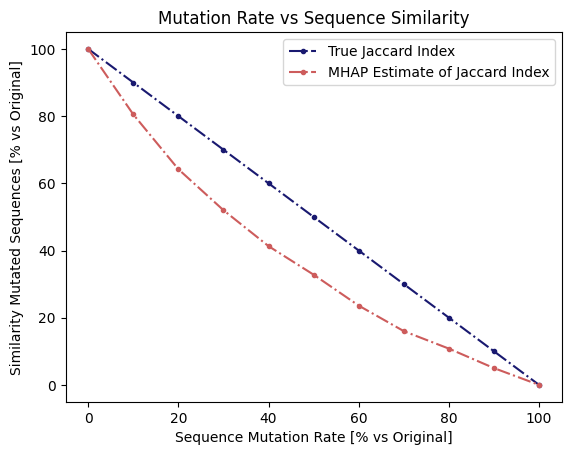

In [48]:
mutation_rate = [100*i*0.1 for i in range(0,11,1)]
plt.plot(mutation_rate,true_similarity, '.-.',label='True Jaccard Index',color='midnightblue')
plt.plot(mutation_rate,indices,'.-.',label='MHAP Estimate of Jaccard Index',color='indianred')
plt.xlabel('Sequence Mutation Rate [% vs Original]')
plt.ylabel('Similarity Mutated Sequences [% vs Original]')
plt.title('Mutation Rate vs Sequence Similarity')
plt.legend()
plt.show()

In [ ]:
scores = []
seqs = []
# Open the FASTQ file and parse it
with open('filtered_reads.fastq', 'r') as file:
    # Parse the file record by record
    for record in SeqIO.parse(file, 'fastq'):
        # Process each record as needed
        #rint(record.id)  # Example: Print record ID
        #print(record.seq)  # Example: Print sequence
        seqs.append(record.seq)
        scores.append(record.letter_annotations["phred_quality"])  # Example: Print quality scores

In [ ]:
seqs = [str(s) for s in seqs]
len(seqs)

In [ ]:
seq_idxs = [i for i in range(len(seqs))]
seq_idxs[-1]

In [ ]:
seq_subset = seqs[::1000]
# seq_subset = seqs[:100]
len(seq_subset)

In [ ]:
seq_subset = seqs[::1000]
all_sketches_v1 = get_all_sketches(seq_subset,seed)

In [ ]:
j_mtx = get_jaccard_matrix(all_sketches_v1,0.12)

In [ ]:
count_nondiagonal = 0

for row in j_mtx:
  if list(row).count(1) > 1:
    count_nondiagonal+=1
    print(row)

print(count_nondiagonal)

In [ ]:
seq_subset_v2 = seqs[:100]
all_sketches_v2 = get_all_sketches(seq_subset_v2,seed)

In [ ]:
j_mtx_v2 = get_jaccard_matrix(all_sketches,0.03)

count_nondiagonal = 0

for row in j_mtx_v2:
  if list(row).count(1) > 1:
    count_nondiagonal+=1
    print(row)

print(count_nondiagonal)

In [ ]:
# from concurrent.futures import ThreadPoolExecutor
# from typing import List
# import numpy as np

# def get_all_sketches(reads: List[str], seed: int) -> List[np.ndarray]:
#     def process_read(read):
#         all_kmers = create_kmers(read, k=CONSTANT_k)
#         return create_sketch(all_kmers, seed)

#     with ThreadPoolExecutor() as executor:
#         all_sketches = list(executor.map(process_read, reads))

#     return all_sketches
#######################################################
# from concurrent.futures import ThreadPoolExecutor
# from typing import List
# import numpy as np

# def get_all_sketches(reads: List[str], seed: int) -> List[np.ndarray]:
#     start_time = time.time()
#     end_time: float = 0.0
#     total_reads = len(reads)
#     tenth = total_reads // 10
#     progress = 0

#     def process_read(read):
#         nonlocal progress
#         all_kmers = create_kmers(read, k=CONSTANT_k)
#         progress += 1
#         if progress % tenth == 0:
#             end_time = time.time()
#             print(f"{progress / total_reads * 100:.0f}% of reads processed, seconds elapsed = {end_time - start_time}")
#         return create_sketch(all_kmers, seed)

#     with ThreadPoolExecutor() as executor:
#         all_sketches = list(executor.map(process_read, reads))

#     print(f"TOTAL seconds elapsed = {end_time - start_time}")
#     return all_sketches


In [ ]:
seq_subset = seqs[::1000]
all_sketches_v1 = get_all_sketches(seq_subset,seed)

In [ ]:
num_reads = len(seqs)

dummy = np.zeros(shape=(num_reads,num_reads))

In [ ]:
for i in range(0,num_reads):
  for j in range(i,num_reads):
    if i % 2 == 0:
      dummy[i][j] = 1

In [ ]:
!lscpu | grep -E '^Thread|^Core|^Socket|^CPU\('

In [ ]:
# from multiprocessing import Pool

# def worker(read_and_seed):
#     read, seed = read_and_seed
#     all_kmers_i = create_kmers(read, k=CONSTANT_k)
#     return create_sketch(all_kmers_i, seed)

# def get_all_sketches(reads: List[str], seed: int) -> List[np.ndarray]:
#     with Pool() as pool:
#         all_sketches = pool.map(worker, [(read, seed) for read in reads])
#     return all_sketches

from multiprocessing import Pool
from tqdm import tqdm

def worker(read_and_seed):
    read, seed = read_and_seed
    all_kmers_i = create_kmers(read, k=CONSTANT_k)
    return create_sketch(all_kmers_i, seed)

def get_all_sketches_parallel(reads: List[str], seed: int) -> List[np.ndarray]:
    with Pool() as pool:
        all_sketches = list(tqdm(pool.imap(worker, [(read, seed) for read in reads]), total=len(reads), unit='read'))
    return all_sketches

In [ ]:
seq_subset = seqs[::1000]
all_sketches_v1 = get_all_sketches_parallel(seq_subset,seed)